In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scipy
from sklearn.cluster import KMeans
import ipywidgets as widgets

from mastodon_functions import xml_features, csv_features, ordering_tracks_all
from paleo_functions import smoothing_filter, peak_detection

# 3 - Phase Analysis of cell tracks 

In this notebook we will import the .csv files obtained from Mastodon to have a first look on how the cell tracks look like. Here we will play with the tags, subtags and observe the dividing cells. 

## Folder and data paths
In the next cell, you need to specify:
- ``path_xml``: Path and file name of the .xml file obtained from converting the data to HDF5/XML is stored.
- ``path_csv``: Path and file name of the .csv file obtained from the tracks from Mastodon. You do not need to add the -edges or -vertices extension.

In [2]:
position = 2

# Path to .xml file generated when creating the .hdf5
path_xml = '../Data/Position%d_20191213.xml'%position # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = '../Data/Position%d-20191213-v19'%position 

## Image characteristics

Because we stored the data as an XML/HDF5, the .xml file contains all the metadata we need. We will now extract it in order to know pixel size, number of planes, image dimensions  and total number of timepoints. 

You only need to specify the temporal resolution in seconds that you used to acquire the data (``tr``). 

In [3]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = round(tr/60,2) # in minutes

fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


In [18]:
fts.

AttributeError: 'xml_features' object has no attribute 'keys'

## Data organization: build the cell tracks

The function ``csv_features`` obtain all the features from each individual spot as a single unit. These spots are then rearranged according to their cell track and using the function ``ordering_tracks``. As a result, we get two new objects called ``spots`` and ``tracks``.

By pressing ``spots.`` + <kbd>TAB</kbd> or ``tracks.`` + <kbd>TAB</kbd>, a list will pop with all the different variables you can obtain from the spot object or the tracks obtject. 

In [4]:
# Function to obtain all the spots' information from the .csv file
spots = csv_features(path_csv, path_xml)

# Order the time series according to each individual cell
tracks = ordering_tracks_all(path_csv, path_xml)

Arrange Cell Tracks: 100%|██████████| 128/128 [00:04<00:00, 26.68it/s]


## Plot all the cell tracks

Now that we organized the data, the next step is to plot the cell traces we obtained. For now, we will distinguish between dividing and non-dividing cells. 

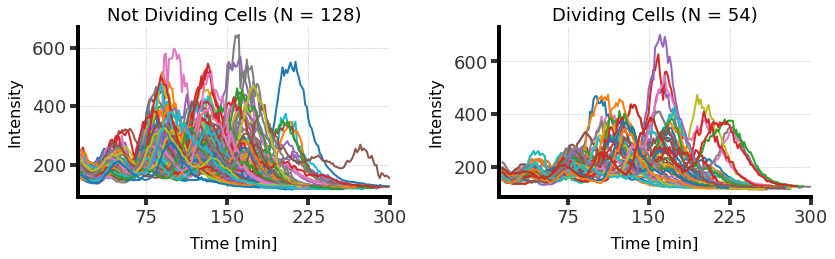

In [5]:
plt.figure(figsize=[12,4])
plt.style.use('mastodon_style.mplstyle')

# Cells that do not divide
plt.subplot(121)
for j in range(tracks.n_tracks_divs):
    if tracks.spots_features['DivID'][j] == 0:
        plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], linewidth=2)

plt.title('Not Dividing Cells (N = %d)'%spots.n_tracks, fontsize = 18)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)))
plt.ylabel('Intensity', fontsize=16)
plt.xlim([8,200])

# Dividing Cells
plt.subplot(122)
for j in range(tracks.n_tracks_divs):
    if tracks.spots_features['DivID'][j] > 0:
        plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], linewidth=2)

plt.title('Dividing Cells (N = %d)'%tracks.n_division_tracks, fontsize = 18)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)))
plt.ylabel('Intensity', fontsize=16)
plt.xlim([8,200])

plt.tight_layout()
plt.show()

## Cell-by-cell

Because we will have an identifier for each individual cell in order to be able to choose the ones we want to analyze in this notebook, we will plot below each individual cell with their ID. This ID can then be mapped back to the track ID from Mastodon in case you want to check the cell trace. 

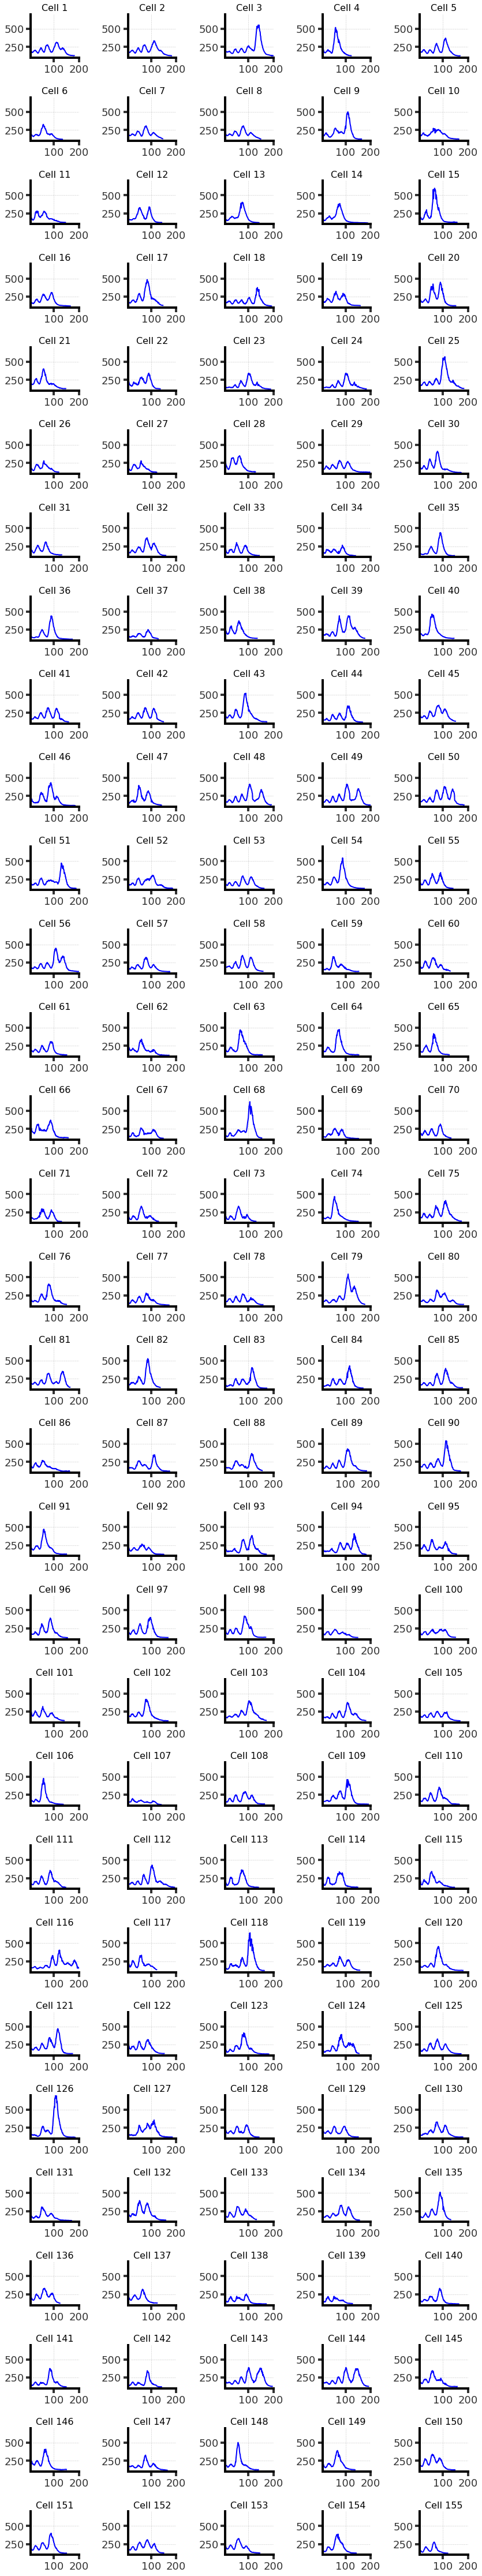

In [6]:
n_cols =  5
n_cells = tracks.n_tracks_divs
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1
size_fig = n_rows*(10/n_cols)
# Initialize the figure size
fig = plt.figure(figsize=[12,size_fig])

for i in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    plt.plot(tracks.spots_features['Frames'][i], tracks.spots_features['Mean1'][i], 
             linewidth=2, color='blue')
    plt.title('Cell %d'%(i+1), fontsize=16)
    plt.xlim([8,200])
    plt.ylim([100,700])
    
plt.tight_layout()
plt.show()   

### Check for each cell, their track ID

For this notebook, each cell has been apointed with a number from 1-``N`` (``N`` being the number of cells you tracked). However, if you want to check which cell is the one you observe using Mastodon, here we provide the first track ID (so the track ID of the first timepoint of each cell). This way you can then check in Mastodon how does this cell behave. 

In [7]:
foo = list(np.arange(tracks.n_tracks_divs)) # List to use

 
# Function for the button to select user input and do work
def get_user_selection(a): # A default arg is needed here, I am guessing to pass self
    # Displays the current value of dropbox1 and dropbox two
    display(dropbox1.value)


# creation of a widget dropdown object called dropbox1
dropbox1 = widgets.Dropdown(
    options=foo, # Object to iterate over
    description='Cells ID:', # User defined 
    value=foo[1], # Default value selection
    rows=len(foo), # The number of rows to display when showing the box
    interactive=True, # This makes the box interactive, I believe this is true by default
);


# Create a UI object to display things.  There are other ways of organizing them.
ui = widgets.HBox([dropbox1]) # pass an array of widgets to the ui

# display the UI
display(ui)

In [8]:
track_ID_selected = tracks.spots_features['ID'][dropbox1.value][0]
frames_ID_selected = tracks.spots_features['Frames'][dropbox1.value][0]

print('The cell # %d has a Track ID # %d for Frame %d.'%(dropbox1.value, track_ID_selected, frames_ID_selected))

The cell # 1 has a Track ID # 336 for Frame 10.


## Neighboring cells Analysis

### Find Neighboring cells

According to Delaume et al., 2012 a neighboring cells is that which is within a distance of 10 $\mu$m (cell diameter) of each other. You can choose the ``cell_dist`` (in $\mu$m) you think is better for your purpuse. 

In [9]:
cell_dist = 10 # In micrometer

In [10]:

# Save the neighbors' IDs
cell_neighbors = []


for j in range(tracks.n_tracks_divs):
    
    # Position of cell 1
    x1 = tracks.spots_features['X'][j][0]
    y1 = tracks.spots_features['Y'][j][0]
    z1 = tracks.spots_features['Z'][j][0]
    
    aux = []
    
    for i in range(j+1, tracks.n_tracks_divs):
        # Position of cell 2
        x2 = tracks.spots_features['X'][i][0]
        y2 = tracks.spots_features['Y'][i][0]
        z2 = tracks.spots_features['Z'][i][0]
        
        aux_dist = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        
        if aux_dist <= cell_dist:
            
            # If both cells divide
            if tracks.spots_features['DivID'][i] > 0 and tracks.spots_features['DivID'][j]:
                # Check if these cells are siblings? Only save if they are not
                if tracks.spots_features['DivID'][i] != tracks.spots_features['DivID'][j]:
                    aux.append([i,j])
                    
            # If only one divides or non of them divide, always safe
            else:
                aux.append([i,j])

    # Save only if there is something to save
    if np.size(aux)>0:
        cell_neighbors.append(np.unique(aux))

### Plot the neighboring cells and the siblings

In the next Jupyter cell, we will show you for each cell, its neighbours and in the case of division its siblings. For this, we color coded the cells:

<img src="../Images-Notebook/NeighboursSiblings-colors.png" width="300" align="center">

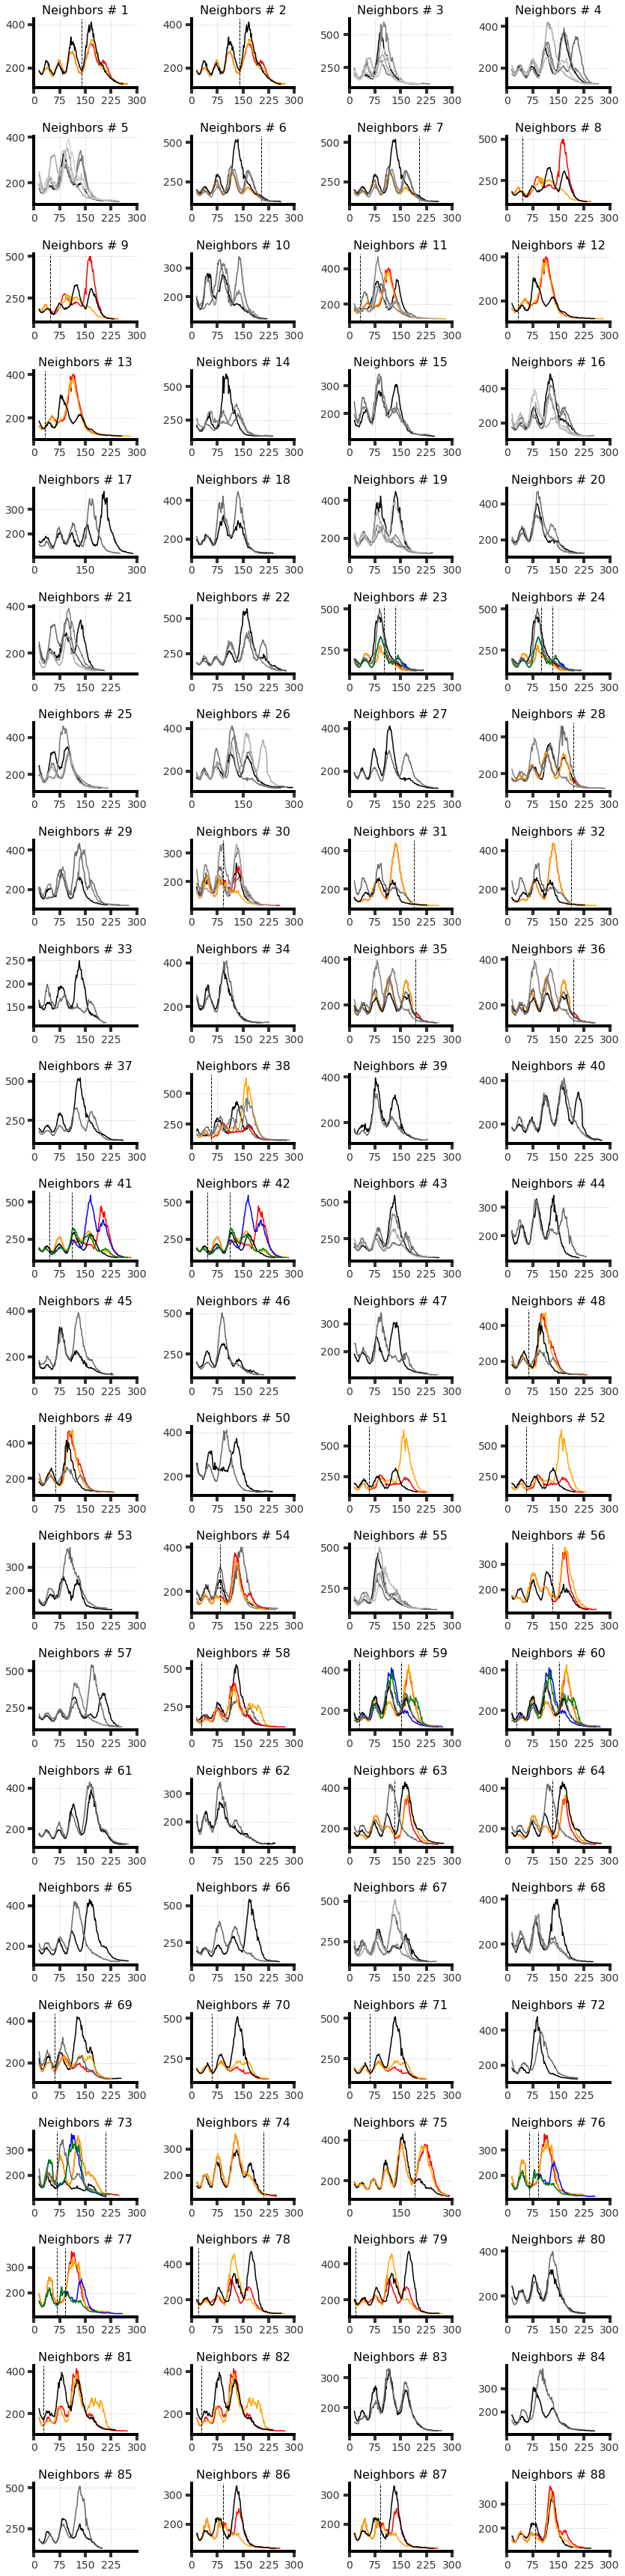

In [11]:
# Find the timepoit where the cells divide
def Diff(li1, li2): 
    return np.where(np.array(list1)==[item for item in list1 if item not in list2][0])[0]

colors = ['black', 'dimgray', 'gray', 'darkgray', 'silver', 'lightgray']
colors_div = ['red', 'orange', 'blue', 'green', 'magenta', 'cyan', 'yellow', 'limegreen']

# Define the dimensions of the subplot
n_cols =  4
n_cells = len(cell_neighbors)
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[12,50])


# For each neighboring clutch
for i in range(len(cell_neighbors)):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    # Number of cells in a neighborhood
    neighbors = cell_neighbors[i]
    count1 = 0
    count2 = 0          
    
    div_aux = []
    
    for j in neighbors:
        
        # If this cell does not divide, plot in grey
        if tracks.spots_features['DivID'][j]==0:
            plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], color=colors[count1], linewidth=1.5)
            count1 +=1 

        if tracks.spots_features['DivID'][j]>0:

            # Keep track of the ID of dividing cells to not repeat them
            if np.size(div_aux)==0:
                # First find the other sibling:
                ind1 = tracks.spots_features['DivID'][j]
                ind2 = np.where(np.array(tracks.spots_features['DivID'])==ind1)[0]
                div_aux += list(ind2)
            else:
                # First find the other sibling:
                ind1 = tracks.spots_features['DivID'][j]
                ind2 = np.where(np.array(tracks.spots_features['DivID'])==ind1)[0]

                aux = set(div_aux).intersection(ind2)
                if np.size(list(aux)) > 0:
                    div_aux += list(ind2)
                    continue
                else:
                    div_aux += list(ind2)
            
            # Plot them in orange and red
            plt.plot(tracks.spots_features['Frames'][ind2[0]], tracks.spots_features['Mean1'][ind2[0]], color=colors_div[count2], linewidth=1.5)
            plt.plot(tracks.spots_features['Frames'][ind2[1]], tracks.spots_features['Mean1'][ind2[1]], color=colors_div[count2+1], linewidth=1.5)
            count2 += 2
            
            # Find timepoint where cells divide
            list1 = tracks.spots_features['ID'][ind2[0]]
            list2 = tracks.spots_features['ID'][ind2[1]]

            ind = Diff(list1, list2)

            plt.axvline(tracks.spots_features['Frames'][ind2[0]][ind], color='black', linewidth=1, linestyle='--')
    

    plt.title('Neighbors # %d'%(i+1), fontsize=16)
    #plt.xlabel('Time [min]', fontsize=16)
    locs, labels = plt.xticks()
    plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
    plt.yticks(fontsize=14)
    #plt.ylabel('Mean Intensity', fontsize=16)
    plt.xlim([0,200])
    #plt.ylim([100,600])
    
plt.tight_layout()       
    
    

### Crop the last part of the trace 

To perform the Phase analysis, we use only the oscillatory part of the cell, so after the last detected peak, we ignore that area since this could add noise into the Hilbert Transform analysis which will be done later. 

In [12]:
# Peak detection parameters
ind = 0 #8 

# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 7 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

trace_save = []

for j in range(tracks.n_tracks_divs):
    if j!= 74:

        peaks = peak_detection(tracks.spots_features['Mean1'][j], window, th_val, th_val_, \
                               dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_)

        # If no peaks are detected, print the cell number
        if peaks.count > 0:
            print(j+1)

        # Correct for the last peak in case it was not detected:
        y = smoothing_filter(tracks.spots_features['Mean1'][j], window)

        # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
        if np.isnan(y[peaks.peaks_][0]):
            peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1

        # Only keep the part from the last peak towards the end
        offset_traces = tracks.spots_features['Mean1'][j][peaks.peaks[-1]:]
        
        # Cluster data into two groups
        window_ = 5

        trace = offset_traces[~np.isnan(offset_traces)]
        X = np.zeros((len(trace[window_:]),2))
        X[:,0] = trace[window_:]
        X[:,1] = trace[:-window_]
        y_pred = KMeans(n_clusters=2, n_init=200).fit_predict(X)
        ind_cut = np.where(y_pred[window:]==y_pred[-1])[0]+window
        
        # Save the new traces:
        end_trace = peaks.peaks[-1]+ind_cut[0]
        trace_save.append(tracks.spots_features['Mean1'][j][:end_trace])

### Hilbert transform and phase calculation

For the [Hilbert Transform](https://en.wikipedia.org/wiki/Hilbert_transform) calculation we only need the crpped trace (which was done in the above Jupyter cell) and the temporal resoltuion ``tr``. 

Below we show for each cell, the <font color='black'>Original Trace</font>, the <font color='blue'>Hilbert Transform</font> and the <font color='red'>Phase</font>, as shown in the example below:


<img src="../Images-Notebook/HilbertTransform_example.png" width="500" align="center">

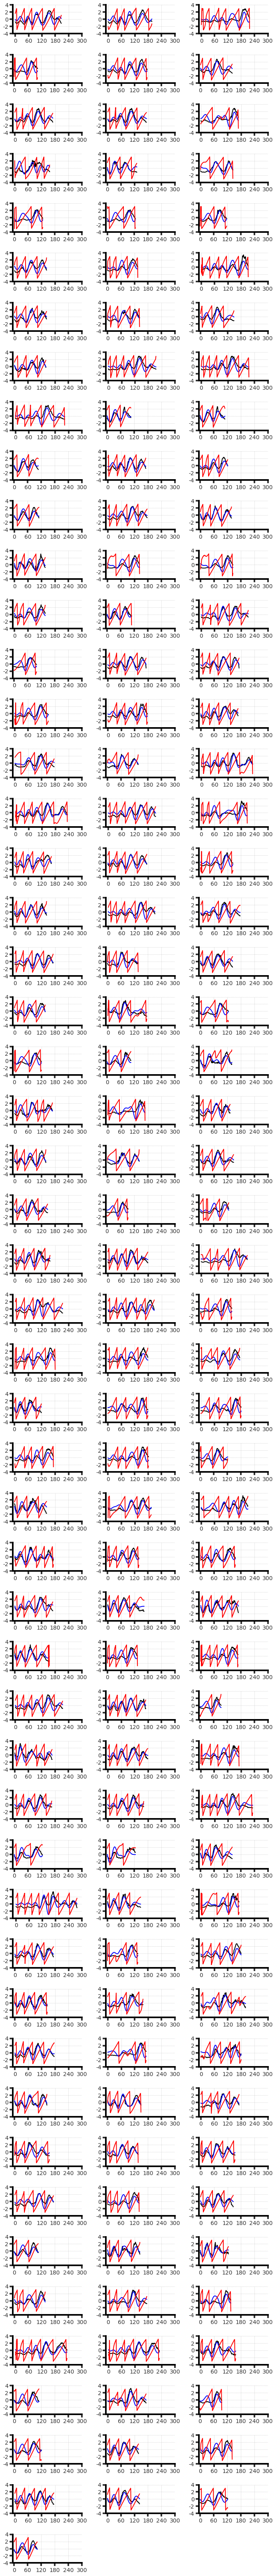

In [13]:
# Parameters 
# sample spacing
T = tr
fs = 1 / T

# Define the dimensions of the subplot
n_cols =  3
n_cells = len(trace_save)
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

phase_save = []

# Initialize the figure size
ax = plt.figure(figsize=[10,90])

for j in range(n_cells):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1

    # Time trace   
    y = trace_save[j]

    # Number of samplepoints
    N = len(y)

    x = np.linspace(0.0, N*T, N)

    # Butterworth filter
    b, a = scipy.signal.butter(N=6, Wn=[0.0002,0.0006],fs=1/90,  btype='band')
    y_filt = scipy.signal.filtfilt(b, a, y)

    # Hilbert Transform
    analytic_signal_filt = scipy.signal.hilbert(y_filt)

    # Phase calculation
    instantaneous_phase_filt = np.angle(analytic_signal_filt)

    phase_save.append(instantaneous_phase_filt)

    plt.plot(x, scipy.stats.zscore(y), color='black', linewidth=2, label='original')
    plt.plot(x,  scipy.stats.zscore(y_filt), color='blue', linewidth=2, label='filtered')
    plt.plot(x,  instantaneous_phase_filt, color='red',linewidth=2, label='filtered-phase')
    plt.xticks(np.arange(0,360,60)*60, np.arange(0,360,60),fontsize=14)
    plt.yticks(np.arange(-4,5,2), np.arange(-4,5,2), fontsize=14)
    #plt.xlabel('Time [min]', fontsize=16)
    #plt.ylabel('Z-Score', fontsize=16)
        
plt.tight_layout()
plt.show()

## Cells Division Analysis

Before we checked neighboring cells and whether any of those divided. In this case we check only the cells that divide and we check their neighbors within a certain distance ``cell_dist``in $\mu$m. 

In [14]:
cell_dist = 10 # In micrometer

In [15]:
# First find the list of cells that divide

div_inds_aux = []
aux = []

for j in range(tracks.n_tracks_divs):
    if tracks.spots_features['DivID'][j]>0:
        div_inds_aux.append(j)
        aux.append(tracks.spots_features['DivID'][j])

# Indices of dividing cells
div_inds = np.array(div_inds_aux)[np.array([aux.index(x) for x in set(aux)])]

# Indices of cells that do not divide
all_inds = np.arange(tracks.n_tracks_divs)
no_div_inds = list(set(all_inds)-set(div_inds))

In [16]:
# Save the neighbors' IDs
cell_neighbors = []


for j in div_inds:
    
    # Position of cell 1
    x1 = tracks.spots_features['X'][j][0]
    y1 = tracks.spots_features['Y'][j][0]
    z1 = tracks.spots_features['Z'][j][0]
    
    aux = []
    
    for i in no_div_inds:
        # Position of cell 2
        x2 = tracks.spots_features['X'][i][0]
        y2 = tracks.spots_features['Y'][i][0]
        z2 = tracks.spots_features['Z'][i][0]
        
        aux_dist = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        
        if aux_dist <= cell_dist:
            
            # If both cells divide
            if tracks.spots_features['DivID'][i] > 0 and tracks.spots_features['DivID'][j]:
                # Check if these cells are siblings? Only save if they are not
                if tracks.spots_features['DivID'][i] != tracks.spots_features['DivID'][j]:
                    aux.append([i,j])
                    
            # If only one divides or non of them divide, always safe
            else:
                aux.append([i,j])

    # Save only if there is something to save
    if np.size(aux)>0:
        cell_neighbors.append(np.unique(aux))

Same color code as before applies, just remember that this time we only check the cells which divide so the neighbouring cells are the ones close to the cells before division.  

<img src="../Images-Notebook/NeighboursSiblings-colors.png" width="300" align="center">

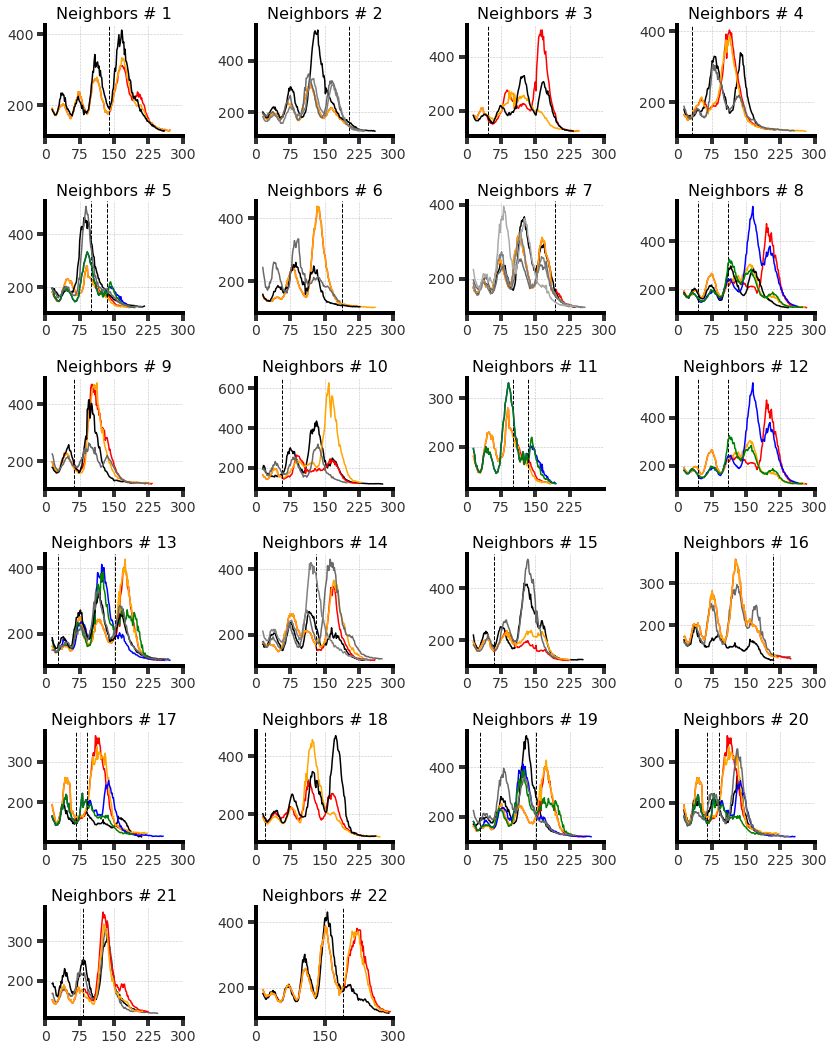

In [17]:
colors = ['black', 'dimgray', 'gray', 'darkgray', 'silver', 'lightgray']
# Define the dimensions of the subplot
n_cols =  4
n_cells = len(cell_neighbors)
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[12,15])

colors_div = ['red', 'orange', 'blue', 'green']

# For each neighboring clutch
for i in range(len(cell_neighbors)):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    # Number of cells in a neighborhood
    neighbors = cell_neighbors[i]
    count1 = 0
    count2 = 0
    for j in neighbors:
        
        # If this cell does not divide, plot in grey
        if tracks.spots_features['DivID'][j]==0:
            plt.plot(tracks.spots_features['Frames'][j], tracks.spots_features['Mean1'][j], color=colors[count1], linewidth=1.5)
            count1 +=1 
            
        if tracks.spots_features['DivID'][j]>0:
            # First find the other sibling:
            ind1 = tracks.spots_features['DivID'][j]
            ind2 = np.where(np.array(tracks.spots_features['DivID'])==ind1)[0]
            
            # Plot them in orange and red
            plt.plot(tracks.spots_features['Frames'][ind2[0]], tracks.spots_features['Mean1'][ind2[0]], color=colors_div[count2], linewidth=1.5)
            plt.plot(tracks.spots_features['Frames'][ind2[1]], tracks.spots_features['Mean1'][ind2[1]], color=colors_div[count2+1], linewidth=1.5)
            count2 +=2
            
            # Find timepoint where cells divide
            list1 = tracks.spots_features['ID'][ind2[0]]
            list2 = tracks.spots_features['ID'][ind2[1]]

            ind = Diff(list1, list2)

            plt.axvline(tracks.spots_features['Frames'][ind2[0]][ind], color='black', linewidth=1, linestyle='--')
    

    plt.title('Neighbors # %d'%(i+1), fontsize=16)
    #plt.xlabel('Time [min]', fontsize=16)
    locs, labels = plt.xticks()
    plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
    plt.yticks(fontsize=14)
    #plt.ylabel('Mean Intensity', fontsize=16)
    plt.xlim([0,200])
    #plt.ylim([100,600])
    
plt.tight_layout()       
    
    

### Visualize dividing cells

We can also visualize the siblings cells alone in order to know when they divide (dashed line) and how is their behaviour before and after the cell division. 

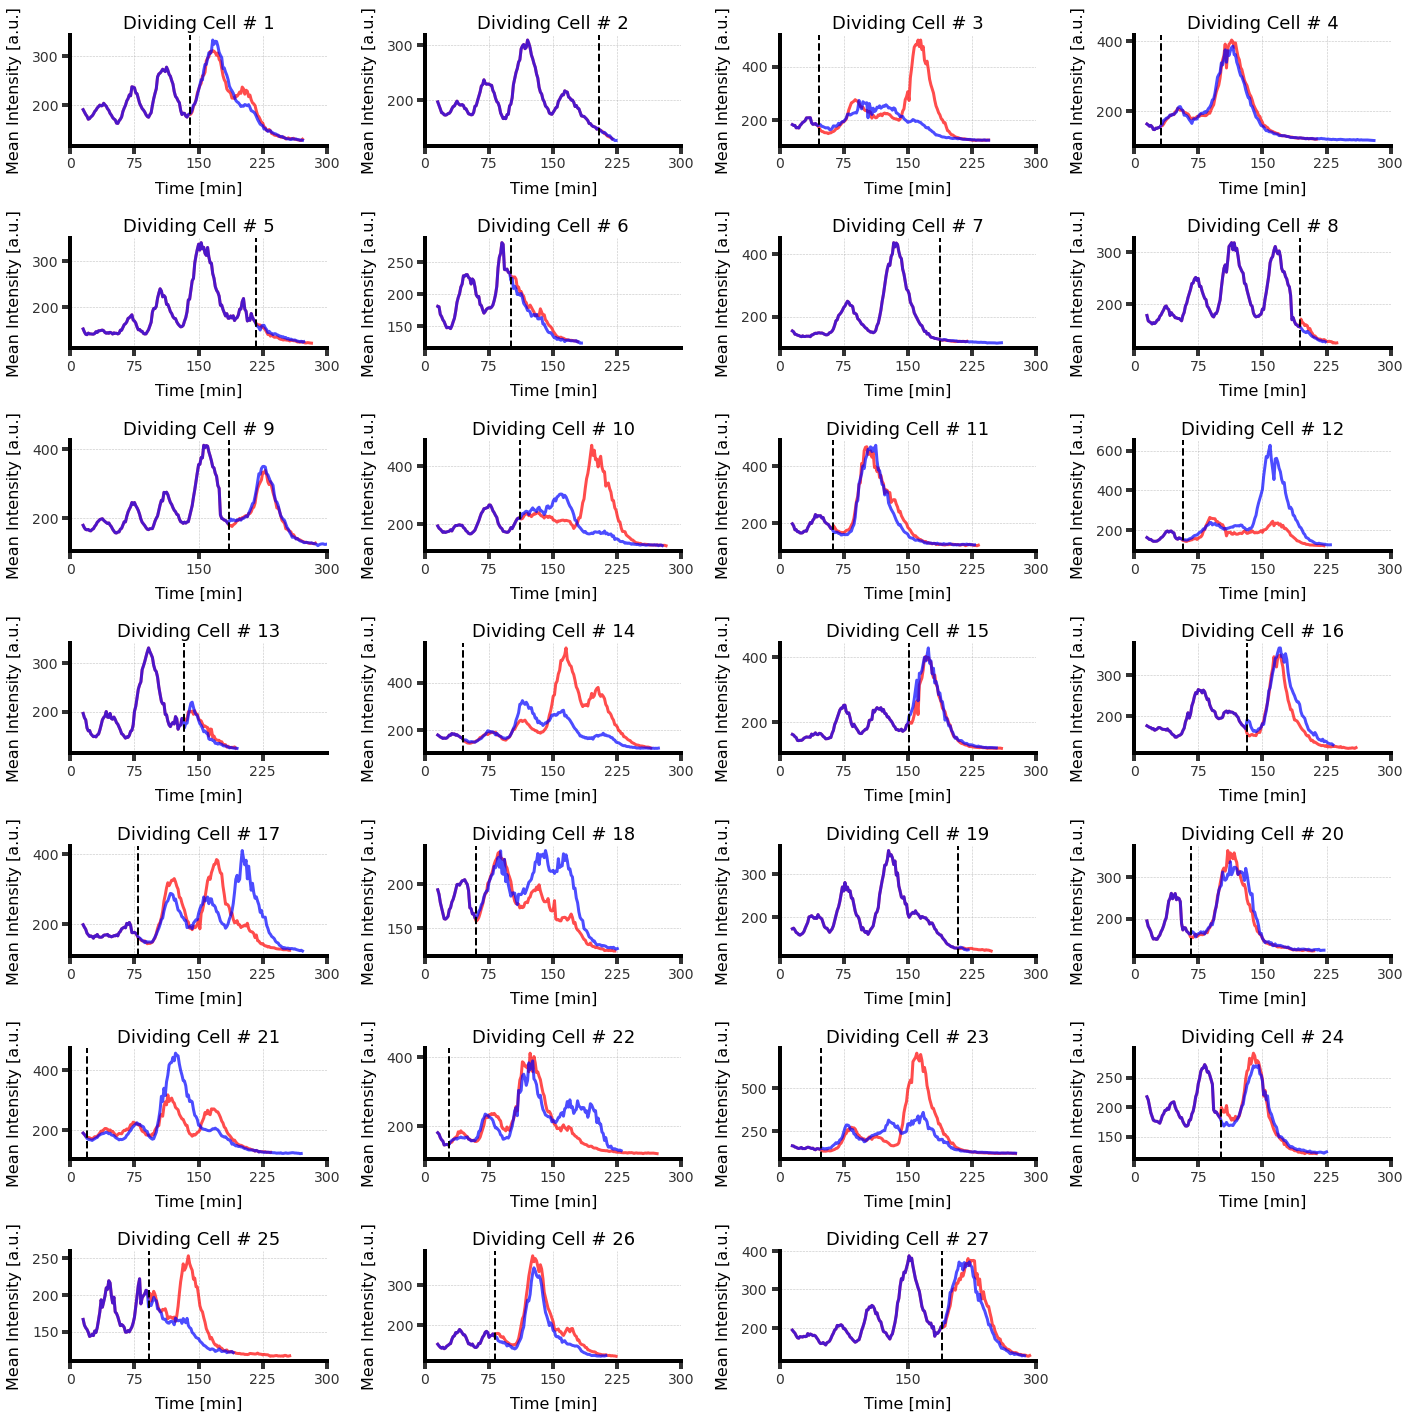

In [18]:
# Find the timepoit where the cells divide
def Diff(li1, li2): 
    return np.where(np.array(list1)==[item for item in list1 if item not in list2][0])[0]

# Number of dividing pairs of cells
n_div_pairs = np.unique(tracks.spots_features['DivID'])[1:]

# Define the dimensions of the subplot
n_cells = len(n_div_pairs) 
n_cols = 4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[20,20])

for j in n_div_pairs:
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    # Find the sisters to plot
    inds = np.where(np.array(tracks.spots_features['DivID'])==j)[0]
    
    # Plot the sisters
    plt.plot(tracks.spots_features['Frames'][inds[0]], tracks.spots_features['Mean1'][inds[0]], linewidth=3, color='red', alpha=0.7)
    plt.plot(tracks.spots_features['Frames'][inds[1]], tracks.spots_features['Mean1'][inds[1]], linewidth=3, color='blue', alpha=0.7)
    
    # Find timepoint where cells divide
    list1 = tracks.spots_features['ID'][inds[0]]
    list2 = tracks.spots_features['ID'][inds[1]]
    
    ind = Diff(list1, list2)
    
    plt.axvline(tracks.spots_features['Frames'][inds[0]][ind], color='black', linewidth=2, linestyle='--')
    
    plt.title('Dividing Cell # %d'%j, fontsize = 18)
    plt.xlabel('Time [min]', fontsize=16)
    locs, labels = plt.xticks()
    plt.xticks(locs, list(map(int,np.round(locs*tr_min))), fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Mean Intensity [a.u.]', fontsize=16)
    plt.xlim([0,200])

plt.tight_layout()
plt.show()   

## Peak Detection Analysis

If you have oscillatory signals and you are interested in detecting maxima and minima in the trace, here we have a peak finder which you can play with the parameters. 

### Data organization

In [19]:
# Align using their temporal position

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan
y_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan
z_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan

# For each track 
for i in range(tracks.n_tracks_divs):
    
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(tracks.spots_features['Frames'][i]):
        tracks_save[i,val] = tracks.spots_features['Mean1'][i][j]
        x_save[i,val] = tracks.spots_features['X'][i][j]
        y_save[i,val] = tracks.spots_features['Y'][i][j]
        z_save[i,val] = tracks.spots_features['Z'][i][j]

### Peak deteciton  - parameters

In [20]:
# Peak detection parameters

j = 0 # Example cell

ind = 0 # Offset_ start from this timepoint

# Threshold
th_val = 0 # For maxima
th_val_ = 0 # For minima

# Prominence
prominence_val = 8.1 # For maxima
prominence_val_ = 2 # For minima

# Width
width_val = 2 # For maxima
width_val_ = 2 # For minima

# Distance
dist_val = 1 # For maxima
dist_val_ = 1 # For minima

# Averaging window size
window = 9

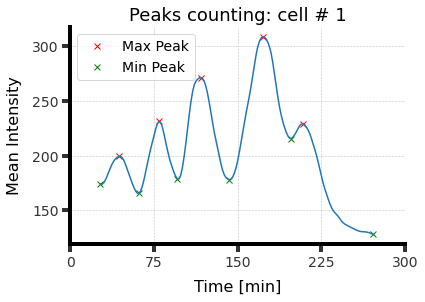

In [21]:
plt.figure(figsize=[6,4])
peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                       dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_)

# If no peaks are detected, print the cell number
if peaks.count > 0 :
    print(j+1)

# Correct for the last peak in case it was not detected:
y = smoothing_filter(tracks_save[j][ind:], window)

# Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1

# Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
if np.isnan(y[peaks.peaks_][0]):
    peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1


plt.plot(peaks.peaks, y[peaks.peaks], "xr"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xg"); plt.plot(y); 
plt.legend(['Max Peak', 'Min Peak'], fontsize=14)
plt.title('Peaks counting: cell # %d'%(j+1), fontsize = 18)
plt.xlabel('Time [min]', fontsize=16)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Mean Intensity', fontsize=16)
plt.xlim([0,200])
plt.show()

Now we will show all the peaks for each individual cell. If one of the cells did not have any detected peaks, the cell ID will be printed so that you know which one it is. 

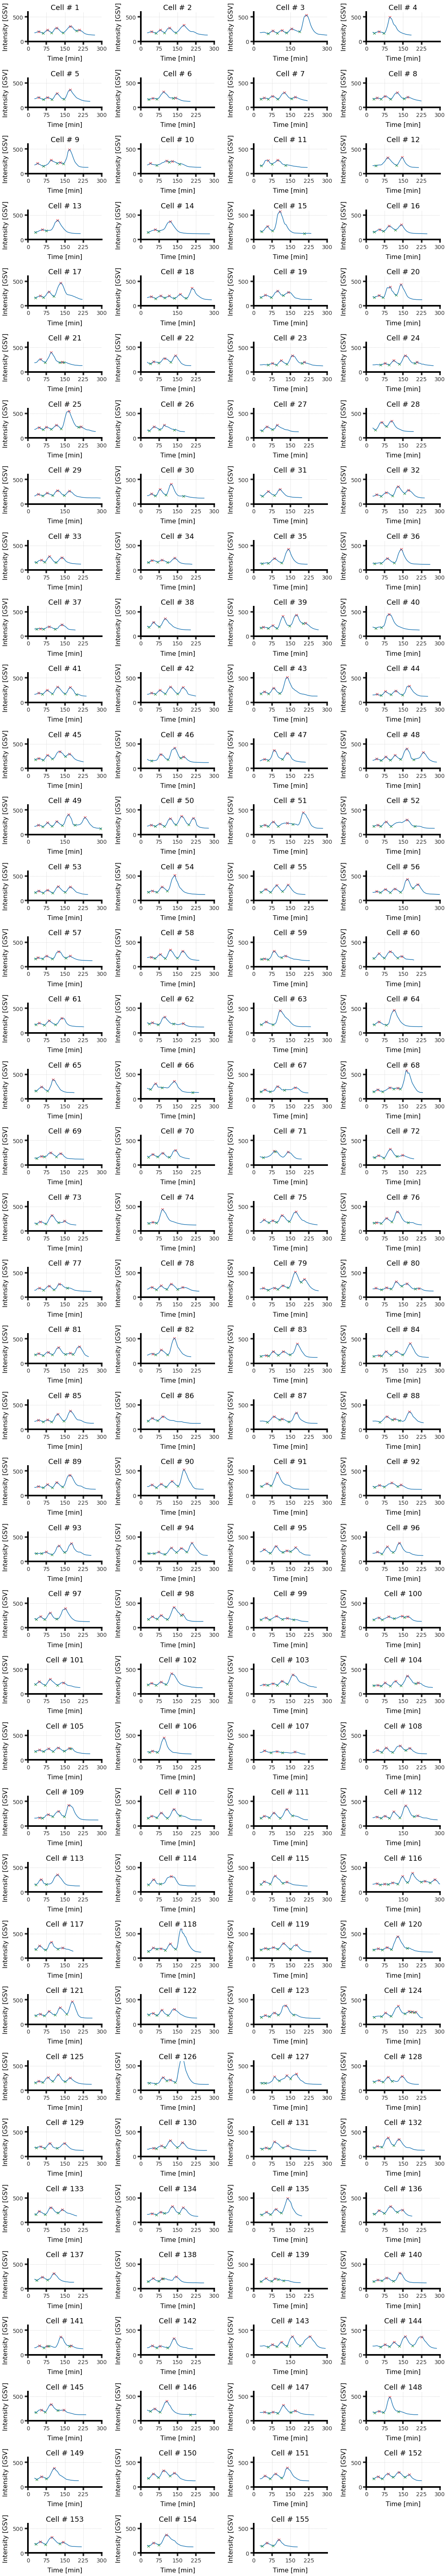

In [22]:

# Define the dimensions of the subplot
n_cells = tracks.n_tracks_divs 
n_cols = 4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[16,90])

for j in range(tracks.n_tracks_divs):
    
    # Update the number of subplots    
    ax = plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_)
    
    # If no peaks are detected, print the cell number
    if peaks.count > 0 :
        print(j+1)

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window)
    
    # Add a minimum in the last position of the trace (first position after the last maximum which is not a nan)
    #peaks.peaks_[-1] =  np.where(np.isnan(y))[0][np.where(np.where(np.isnan(y))[0]>peaks.peaks[-1])[0][0]]-1
    
    # Add a minimum in the first position of the trace (first position after the last maximum which is not a nan) in case there is no minima
    # if np.isnan(y[peaks.peaks_][0]):
    #    peaks.peaks_[0] =  np.where(np.where(np.isnan(y))[0]<peaks.peaks[0])[0][-1]+1
    

    plt.plot(peaks.peaks, y[peaks.peaks], "xr"); plt.plot(peaks.peaks_, y[peaks.peaks_], "xg"); plt.plot(y); #plt.legend(['Max Peak', 'Min Peak'])
    plt.title('Cell # %d'%(j+1), fontsize = 18)
    plt.xlabel('Time [min]', fontsize=16)
    locs, labels = plt.xticks()
    plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Intensity [GSV]', fontsize=16)
    plt.xlim([0,200])
    plt.ylim([0,600])
    
plt.tight_layout()
plt.show()

### Calculate the period (difference between two maxima)

Calculate the difference between each maximum consecutive peaks in order to obtain a sense of the period: 
$ \text{Max}(peak[2]) - \text{Max}(peak[1]) $

In [23]:
# For oscillations in the tailbud
periods = []
n_peaks = []

for j in range(tracks.n_tracks_divs):
    peaks = peak_detection(tracks_save[j][ind:], window, th_val, th_val_, \
                           dist_val, dist_val_, prominence_val,prominence_val_, width_val, width_val_)
    
    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(tracks_save[j][ind:], window) 
    
    # Calculate the period: difference between two maxima
    periods.append(np.diff(peaks.peaks))
    n_peaks.append(len(peaks.peaks))

### Calculate successive peak ratio 
$Period[t+1]/Period[t]$

In [24]:
ratios = []
for i in range(len(periods)):
    
    # If there are at least 2 cycles
    if len(periods[i])>1:
        
        aux = []
        
        # For each period, calculate the ratio
        for j in range(1,len(periods[i])):
            aux.append(periods[i][j]/periods[i][j-1])
        
        ratios += aux

In [29]:
import pandas as pd
import seaborn as sns
plt.style.use('default')
fig = plt.figure(figsize=[6,4])
sns.swarmplot(x=np.ones(len(ratios)), y=np.array(ratios),orient='v', color='gray',  size=5, edgecolor='black', linewidth=2)
plt.axhline(1, linewidth=3, color='red', alpha=0.6)
plt.xticks([], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Ratio', fontsize=16)

plt.ylim([0,2.1])
plt.show()
print('Mean: %g'%np.mean(ratios))
print('Standard Deviation: %g'%np.std(ratios))

ModuleNotFoundError: No module named 'seaborn'

### Number of peaks

In [30]:
aux = []
n_cycles_unique = np.unique(n_peaks)
for i in range(8):
    ind = i+1
    if any(ind == n_cycles_unique):
        ind_where = np.where(ind == np.array(n_peaks))[0]
        aux.append(len(ind_where))
    else:
        aux.append(0)
    
percent_cells = pd.DataFrame(np.array(aux))

<Figure size 432x288 with 0 Axes>

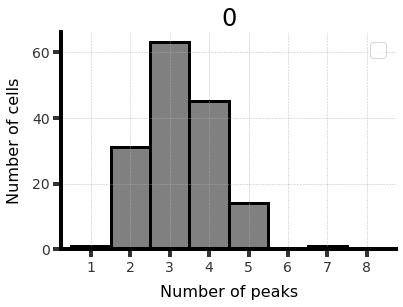

Mean: 3.28387
Standard Deviation: 0.948716


<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(figsize=[6,4])

percent_cells.plot.bar(rot=0, subplots=True, color='gray', edgecolor='black', 
                           linewidth=3, width=1)
plt.xticks([0,1,2,3,4,5,6,7],[1,2,3,4,5,6,7,8], fontsize=14)
plt.yticks(fontsize=14)
plt.legend([])
plt.xlabel('Number of peaks', fontsize=16)
plt.ylabel('Number of cells', fontsize=16)


fig1 = plt.gcf()
plt.show()
plt.draw()

print('Mean: %g'%np.mean(n_peaks))
print('Standard Deviation: %g'%np.std(n_peaks))